# Implementing the code from
https://www.tensorflow.org/tutorials/generative/cyclegan

In [11]:
#!pip install git+https://github.com/tensorflow/examples.git

#use curl to download from the github path
#!curl -LO https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
    
#the copy paste the .py file into this path
#C:\Users\akarunakaran1\Documents\TypeB_Time_Machine\model_pix2pix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  284k    0  284k    0     0   331k      0 --:--:-- --:--:-- --:--:--  331k


In [19]:
#!pip install keras

## Import libraries

In [1]:
import tensorflow as tf

In [2]:
import tensorflow_datasets as tfds

import sys 
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE




from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray
from numpy import vstack
from numpy import savez_compressed
from numpy import load
from matplotlib import pyplot

In [3]:
#now import the python files
# sys.path.append('../')
sys.path.append("C:/Users/akarunakaran1/Documents/TypeB_Time_Machine/model_pix2pix/examples-master")
from tensorflow_examples.models.pix2pix import pix2pix

In [24]:
#dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                              with_info=True, as_supervised=True)

#train_horses, train_zebras = dataset['trainA'], dataset['trainB']
#test_horses, test_zebras = dataset['testA'], dataset['testB']

## Import dataset and define user functions

In [4]:
# load all images in a directory into memory
def load_images(path, size=(286,286)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [5]:
# dataset path
path = 'C:/Users/akarunakaran1/Documents/TypeB_Time_Machine/TypeB_Time_Machine/'

#train_horses  => young ppl photos
#train_zebras  => old ppl photos
#test_horses   => young ppl photos 
#test_zebras   => old ppl photos

# load dataset young
train_horses_to_tf = load_images(path + 'TrainA/')
test_horses_to_tf = load_images(path + 'TestA/')
dataA = vstack((train_horses_to_tf, test_horses_to_tf))
print('Loaded dataA: ', dataA.shape)

# load dataset old
train_zebras_to_tf = load_images(path + 'TrainB/')
test_zebras_to_tf = load_images(path + 'TestB/')
dataB = vstack((train_zebras_to_tf, test_zebras_to_tf))
print('Loaded dataB: ', dataB.shape)

Loaded dataA:  (1150, 286, 286, 3)
Loaded dataB:  (1150, 286, 286, 3)


In [6]:
#https://www.tensorflow.org/guide/data
#https://stackoverflow.com/questions/37340129/tensorflow-training-on-my-own-image

# step 1 - for horses
labels_train_horses = tf.convert_to_tensor([0] * train_zebras_to_tf.shape[0])
labels_test_horses = tf.convert_to_tensor([0] * test_horses_to_tf.shape[0])

train_horses = tf.data.Dataset.from_tensor_slices((train_horses_to_tf,labels_train_horses))
test_horses  = tf.data.Dataset.from_tensor_slices((test_horses_to_tf,labels_test_horses))

In [7]:
# step 1 - for zebras
#filenames = train_horses_to_tf
labels_train_zebras = tf.convert_to_tensor([1] * train_zebras_to_tf.shape[0])
labels_test_zebras = tf.convert_to_tensor([1] * test_zebras_to_tf.shape[0])

train_zebras = tf.data.Dataset.from_tensor_slices((train_zebras_to_tf,labels_train_zebras))
test_zebras  = tf.data.Dataset.from_tensor_slices((test_zebras_to_tf,labels_test_zebras))

## Build code for generator and discriminator

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [10]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [11]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

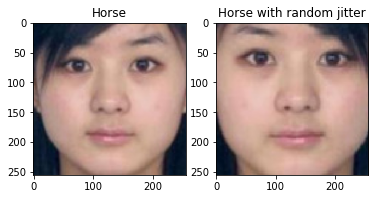

In [13]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

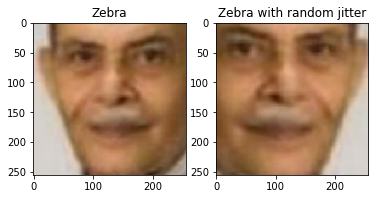

In [14]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

+ make modifications norm_type='instancenorm' ==> norm_type='batchnorm'
+ modify "calc_cycle_loss" L1 loss ==> L2 loss

In [31]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

######################################################################################
#convert to batchnorm
#unet_generator(output_channels, norm_type='batchnorm')
#discriminator(norm_type='batchnorm', target=True)

#generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')
#generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')

#discriminator_x = pix2pix.discriminator(norm_type='batchnorm', target=True)
#discriminator_y = pix2pix.discriminator(norm_type='batchnorm', target=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


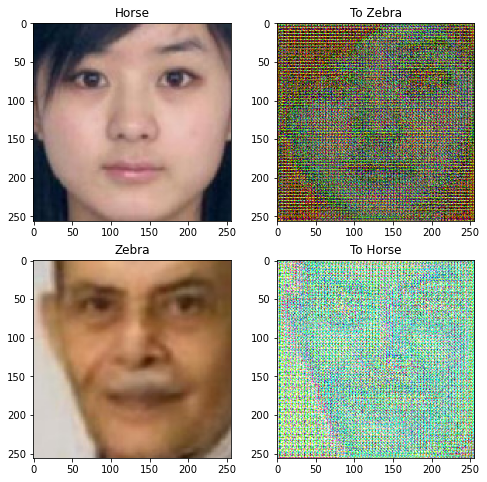

In [32]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

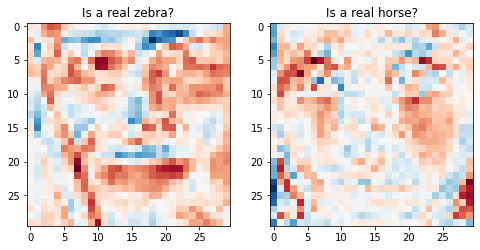

In [36]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In [37]:
LAMBDA = 10

In [38]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [39]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [40]:
def calc_cycle_loss(real_image, cycled_image):
  #loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  #modify to l2 loss
  loss1 = tf.reduce_mean(tf.math.square(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  #loss = tf.reduce_mean(tf.abs(real_image - same_image))
  #modify to l2 loss
  loss = tf.reduce_mean(tf.math.square(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [41]:
#Initialize the optimizers for all the generators and the discriminators.

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [42]:
#checkpoint
#checkpoint_path = "./checkpoints/train"

#set checkpoint folder as follows
checkpoint_path = "./TypeB_Time_Machine/pix2pix_checkpoint"
    
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [25]:
import os
os.getcwd()

'C:\\Users\\akarunakaran1\\Documents\\TypeB_Time_Machine'

## Training

In [27]:
EPOCHS = 1 #40 #initially set epoch as 1

In [43]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [44]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

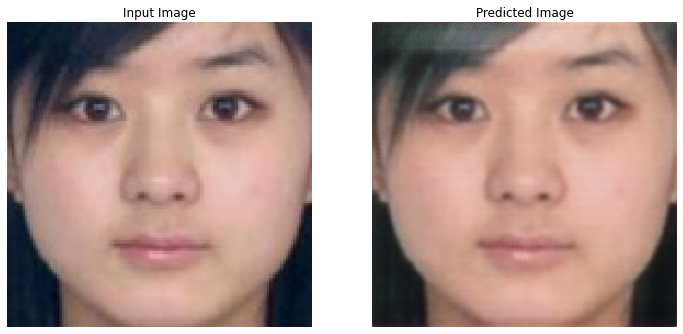

Time taken for epoch 1 is 9435.32926440239 sec



In [45]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [46]:
#save checkpoint - try
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

Saving checkpoint for epoch 1 at ./TypeB_Time_Machine/pix2pix_checkpoint\ckpt-1


## Generate using test dataset

In [47]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [1,4,4,512] vs. shape[1] = [1,3,3,512] [Op:ConcatV2] name: concat

In [48]:
test_horses

<BatchDataset shapes: (None, 286, 286, 3), types: tf.float32>

## Reference
+ https://machinelearningmastery.com/cyclegan-tutorial-with-keras/
+ https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_ganhorse2zebra
+ https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
+ https://www.tensorflow.org/tutorials/generative/cyclegan
+ https://stackoverflow.com/questions/4492979/git-is-not-recognized-as-an-internal-or-external-command